In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [2]:
batch_size = 64  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = 25000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../input/deueng/deu.txt'
val = 10

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 25000
Number of unique input tokens: 72
Number of unique output tokens: 93
Max sequence length for inputs: 19
Max sequence length for outputs: 74


In [6]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [7]:
print(len(input_texts))
print(len(target_texts))
val_data_count = int(len(input_texts) * val / 100)
train_data_count = len(input_texts) - val_data_count
print("val_data_count: ", val_data_count)
print("train_data_count: ", train_data_count)

25000
25000
val_data_count:  2500
train_data_count:  22500


In [8]:
input_texts_train = input_texts[:train_data_count]
target_texts_train = target_texts[:train_data_count]
# shuffle
indices = np.arange(len(input_texts_train))
np.random.shuffle(indices)
input_texts_train_n = list()
target_texts_train_n = list()
for i in indices:
    print(input_texts_train[i])
    print(target_texts_train[i])
    input_texts_train_n.append(input_texts_train[i])
    target_texts_train_n.append(target_texts_train[i])
input_texts_train = None
target_texts_train = None
input_texts_val = input_texts[train_data_count:]
target_texts_val = target_texts[train_data_count:]

Tom, wake up.
	Steh auf, Tom!

It rained heavily.
	Es regnete heftig.

No kidding?
	Wirklich?

This is my coach.
	Das ist mein Trainer.

They work hard.
	Sie strengen sich an.

I was sent home.
	Ich wurde nach Hause geschickt.

Clean that window.
	Mach das Fenster sauber.

Show it to me.
	Zeig ihn mir.

She is beautiful.
	Sie ist schön.

The lovers kissed.
	Die Liebenden küssten sich.

Tom is faithful.
	Tom ist treu.

Step aside.
	Gehen Sie zur Seite!

Stop lying.
	Hört auf zu lügen!

Mary is my aunt.
	Mary ist meine Tante.

The sky is clear.
	Der Himmel ist klar.

Tom sounded mad.
	Tom klang verrückt.

Nobody warned me.
	Keiner hat mich gewarnt.

It's their choice.
	Sie haben die Wahl.

Let's see it.
	Zeigen Sie’s mal her.

This is a fact.
	Das ist eine Tatsache.

Whose are these?
	Wem gehören die?

Stop there.
	Bleib dort stehen.

We'll go out.
	Wir werden ausgehen.

You're the cook.
	Du bist der Koch.

Cut it in half.
	Schneide es in zwei Teile.

I envy her.
	Ich beneide sie.

I usu

	Ich habe es einfach getan.

Get off of me.
	Runter von mir!

Shut the door.
	Mach die Türe zu.

I have a visa.
	Ich habe ein Visum.

Take control.
	Übernehmen Sie die Kontrolle.

There's the rub.
	Da liegt der Hase im Pfeffer!

Tom was there.
	Tom war da.

Let me see.
	Lass mich sehen.

He stared at me.
	Er starrte mich an.

The room was dark.
	Es war dunkel im Zimmer.

He's over thirty.
	Er ist über dreißig.

We forgot.
	Wir haben es vergessen.

Let me see that.
	Lasst mich sehen.

The bill, please.
	Die Rechnung, bitte.

Tom sang a song.
	Tom sang ein Lied.

She sings well.
	Sie singt gut.

I often wear blue.
	Ich trage oft Blau.

I cared about Tom.
	Ich machte mir Sorgen um Tom.

Did you read that?
	Hast du das gelesen?

I downloaded it.
	Ich habe sie heruntergeladen.

You're selfish.
	Du bist selbstsüchtig.

I want one, too.
	Ich will auch eins.

Tom's resting.
	Tom ruht sich aus.

This is a picture.
	Dies ist ein Bild.

Have a taste.
	Koste mal!

Mom, I'm hungry.
	Mama, ich habe 

That's a fish.
	Das ist ein Fisch.

Tom is selfish.
	Tom ist egoistisch.

Start now.
	Fang jetzt an.

This is our house.
	Das ist unser Haus.

Maybe I was wrong.
	Vielleicht hatte ich unrecht.

Don't interfere.
	Misch dich nicht ein!

I just showered.
	Ich habe gerade geduscht.

It's confusing.
	Das verwirrt.

Vote for me!
	Wähle mich!

What's new?
	Was gibt es Neues?

You've grown.
	Du bist gewachsen.

Take cover!
	Geht in Deckung!

The whistle blew.
	Der Pfiff ertönte.

Tom is good.
	Tom ist brav.

Make a list.
	Mach eine Liste.

Do you love me?
	Lieben Sie mich?

Don't show off.
	Gib nicht an.

We're unlucky.
	Wir haben Pech.

Get out of my way.
	Gehen Sie mir aus dem Weg.

May I join you?
	Darf ich mich dazusetzen?

I have a ring.
	Ich habe einen Ring.

Let me handle Tom.
	Überlassen Sie Tom mir.

It's not funny.
	Es ist nicht lustig.

They're not here.
	Sie sind nicht hier.

I'm hit!
	Ich wurde getroffen!

I miss her a lot.
	Ich vermisse sie sehr.

What's next?
	Was kommt als Näch

	Tom schrieb.

Tom has the keys.
	Tom hat die Schlüssel.

Did you love me?
	Liebtest du mich?

I need some sugar.
	Ich brauche etwas Zucker.

What is it, Tom?
	Was ist, Tom?

Stand aside.
	Geh zur Seite!

It's not a gift.
	Es ist kein Geschenk.

Tom wasn't alive.
	Tom war nicht am Leben.

I feel seasick.
	Ich bin seekrank.

I'm not kidding.
	Ich meine das todernst.

He hates her.
	Er hasst sie.

Forgive Tom.
	Vergebt Tom!

I haven't tried.
	Ich habe es nicht versucht.

Is that your mom?
	Ist das deine Mutter?

Leave the TV on.
	Lasst den Fernseher an!

What is love?
	Was ist Liebe?

I'll go by taxi.
	Ich fahre mit dem Taxi.

Look ahead.
	Schaut nach vorne.

Tom was adopted.
	Tom wurde adoptiert.

Did Tom win again?
	Hat Tom schon wieder gewonnen?

I have sunglasses.
	Ich habe eine Sonnenbrille.

Fix this.
	Reparieren Sie das.

All men are equal.
	Alle Männer sind gleich.

Don't stop here.
	Halte hier nicht!

He made me do it.
	Er hat mich dazu gebracht, es zu tun.

I think I agree.
	Ic

They look good.
	Die sehen gut aus.

Open your eyes.
	Öffnen Sie Ihre Augen.

That's what works.
	So geht das.

Fix this.
	Repariere das.

Tom was stubborn.
	Tom war starrköpfig.

Tom is outspoken.
	Tom ist freimütig.

Tom was present.
	Tom war anwesend.

Go see Tom.
	Geh zu Tom.

Did Tom surrender?
	Hat Tom sich ergeben?

I won't deny that.
	Das werde ich nicht abstreiten.

Let's go!
	Lasst uns gehen.

Look ahead.
	Seien Sie vorausschauend.

Just follow them.
	Folge ihnen einfach!

I'm relaxed.
	Ich bin entspannt.

Tom has kids now.
	Tom hat jetzt Kinder.

Is this your car?
	Ist das dein Auto?

Tom cried.
	Tom weinte.

I like to swim.
	Ich schwimme gern.

It's all I have.
	Das ist alles, was ich habe.

We found it here.
	Wir haben ihn hier gefunden.

Tom is quite shy.
	Tom ist ziemlich schüchtern.

Who's my teacher?
	Wer ist mein Lehrer?

The fire went out.
	Das Feuer erlosch.

Catch the ball.
	Fang den Ball.

I drank a beer.
	Ich habe ein Bier getrunken.

Can't you swim?
	Können Sie 

May I go to bed?
	Darf ich ins Bett gehen?

I'm really old.
	Ich bin wirklich alt.

Show him in.
	Bring ihn herein.

Tom never cried.
	Tom weinte nie.

It's a new day.
	Es ist ein neuer Tag.

She might come.
	Sie kommt vielleicht.

I have brothers.
	Ich habe Brüder.

Tom isn't angry.
	Tom ist nicht verärgert.

Go find Tom.
	Gehe hin und suche Tom!

Trust Tom.
	Vertrauen Sie Tom!

Hand me a towel.
	Gib mir mal ein Handtuch.

We kept in touch.
	Wir sind in Verbindung geblieben.

Isn't Tom afraid?
	Hat Tom keine Angst?

Stop being stupid.
	Hör auf, dumm rumzumachen.

It won't work.
	Das wird nicht funktionieren.

I'm going back.
	Ich gehe zurück.

Hold this.
	Halt das!

Who likes beans?
	Wer isst gerne Bohnen?

Let me do it.
	Lassen Sie mich das erledigen.

He's Austrian.
	Er ist Österreicher.

Keep practicing.
	Üben Sie weiter!

Prepare yourself.
	Mache dich bereit!

Stop bothering me!
	Hör auf mich zu belästigen!

Tom will recover.
	Tom wird sich erholen.

I visited Tom.
	Ich habe Tom b

	Kann ich Sie sprechen?

You need a plan.
	Du brauchst einen Plan.

I didn't listen.
	Ich habe nicht zugehört.

Don't come.
	Kommt nicht!

Leave it to us.
	Überlass das uns!

We'll shoot.
	Wir werden schießen.

Tom hummed along.
	Tom summte mit.

I teach geography.
	Ich bin Erdkundelehrer.

I'll get off here.
	Ich werde hier aussteigen.

I found your keys.
	Ich habe deine Schlüssel gefunden.

Is that your son?
	Ist das euer Sohn?

Hug Tom.
	Umarmen Sie Tom!

This bag is mine.
	Diese Tasche gehört mir.

We had doubts.
	Wir hatten Zweifel.

He bought a Honda.
	Er hat einen Honda gekauft.

I'm not like Tom.
	Ich bin nicht so wie Tom.

The cup broke.
	Die Tasse zerbrach.

I volunteered.
	Ich meldete mich freiwillig.

I'm no expert.
	Ich bin kein Fachmann.

I agreed with her.
	Ich pflichtete ihr bei.

Tom kept writing.
	Tom schrieb weiter.

Warn Tom.
	Warnen Sie Tom.

That's our train.
	Das ist unser Zug.

She isn't picky.
	Sie ist nicht pingelig.

Tom bought rolls.
	Tom hat Brötchen gekauf

	Niemand hat Tom gesehen.

That's ludicrous.
	Das ist lachhaft.

Tom is cheerful.
	Tom ist fröhlich.

They both blushed.
	Alle beide erröteten.

I was too shy.
	Ich war zu schüchtern.

I like to sing.
	Ich singe gerne.

I love you all.
	Ich liebe euch alle.

You are stupid.
	Du bist dumm.

We're back home.
	Wir sind wieder zu Hause.

Give me a sec.
	Gib mir eine Sekunde.

Can you hear me?
	Hört ihr mich?

Tom had to wait.
	Tom musste warten.

You eat too much.
	Ihr esst zu viel.

I just threw up.
	Ich habe mich gerade übergeben.

I like your shirt.
	Ich mag Ihr Hemd.

Tom inspired me.
	Tom hat mich inspiriert.

Are you new?
	Seid ihr neu?

She tied him up.
	Sie fesselte ihn.

He lives above me.
	Er wohnt über mir.

May I quote you?
	Darf ich euch zitieren?

You made Tom cry.
	Du hast Tom zum Weinen gebracht.

I met him.
	Ich habe ihn getroffen.

Tom was out cold.
	Tom war bewusstlos.

We met last week.
	Wir haben uns letzte Woche kennengelernt.

I'm dying.
	Ich werde bald sterben.

Are

	Nimm noch einen.

What is his age?
	Wie alt ist er?

Come on home.
	Komm nach Hause.

The house stank.
	Im Hause stank es.

She's a night owl.
	Sie bleibt gern bis spät in die Nacht hinein auf.

I'm not suicidal.
	Ich bin nicht selbstmordgefährdet.

You know her.
	Du kennst sie.

Tom is young.
	Tom ist jung.

Tom is forgiven.
	Tom wird verziehen.

I'm seldom late.
	Ich komme selten zu spät.

He got very mad.
	Er wurde sehr wütend.

Tom is amazing.
	Tom ist unglaublich.

I came for Tom.
	Ich bin für Tom gekommen.

How was your stay?
	Wie war dein Aufenthalt?

It'll be good.
	Es wird gut sein.

I don't get it.
	Das kapier ich nicht.

He has blond hair.
	Er hat blondes Haar.

I couldn't move.
	Ich konnte mich nicht bewegen.

Take it.
	Nehmt es.

I hate liars.
	Ich kann Lügner nicht leiden.

Tell Tom.
	Sagen Sie es Tom.

Does this count?
	Zählt das?

Leave this to me.
	Lassen Sie mich nur machen.

It isn't a loan.
	Es ist kein Kredit.

I'm illiterate.
	Ich bin Analphabet.

Just let Tom go

Tom likes pizza.
	Tom mag Pizza.

It's up to us.
	Es ist an uns.

Do you deny it?
	Leugnest du?

Your bag's open.
	Ihre Tasche ist offen!

Keep the change.
	Stimmt so.

Tom seems busy.
	Tom scheint beschäftigt zu sein.

Tom is loving.
	Tom ist liebevoll.

I know it was you.
	Ich weiß, dass ihr das wart.

You're late.
	Du kommst spät.

I know Tom is mad.
	Ich weiß, dass Tom wütend ist.

How clever Tom is!
	Wie klug Tom ist!

That's the law.
	So lautet das Gesetz.

I'm OK.
	Es geht mir gut.

We're hiding.
	Wir verstecken uns.

Aren't you busy?
	Sind Sie nicht beschäftigt?

I'm right.
	Ich habe recht.

What's it about?
	Worum geht es?

Are you busy?
	Haben Sie zu tun?

I supported him.
	Ich unterstützte ihn.

Do you want kids?
	Möchtest du Kinder haben?

This is justified.
	Das ist berechtigt.

Tom fed the pigs.
	Tom fütterte die Schweine.

I was on a bike.
	Ich war auf einem Fahrrad.

Control yourself.
	Beherrsche dich!

Keep it.
	Behalt sie!

What is it?
	Was ist das für ein Ding?

Tom 


I know you know.
	Ich weiß, dass du das weißt.

He is a poet.
	Er ist ein Dichter.

We made waffles.
	Wir haben Waffeln gebacken.

Are you serious?
	Meint ihr das ernst?

That's possible.
	Das kann gut sein.

My father is in.
	Mein Vater ist zuhause.

Tom broke his arm.
	Tom brach sich den Arm.

The sky was blue.
	Der Himmel war blau.

Fill up the tank.
	Füll den Tank auf.

Tom doesn't sing.
	Tom singt nicht.

Dogs are barking.
	Hunde bellen.

They're new.
	Sie sind neu.

Thanks anyway.
	Danke trotzdem.

It's a good plan.
	Das ist ein guter Plan.

Can I help you?
	Darf ich Ihnen helfen?

Tom has a cold.
	Tom hat eine Erkältung.

I need them.
	Ich brauche sie.

I'm unusual.
	Ich bin ungewöhnlich.

Show him in.
	Bringen Sie ihn herein.

Don't jump!
	Spring nicht!

Stop showing off!
	Hören Sie auf anzugeben!

It's already late.
	Es ist spät.

I bought a hat.
	Ich kaufte einen Hut.

I took Highway 58.
	Ich hab den Highway 58 genommen.

I didn't tell Tom.
	Ich habe es Tom nicht gesagt.

Yo

	Maria ist Hebamme.

Here's $10.00.
	Hier sind 10,00 $.

He sat on the bed.
	Er saß auf dem Bett.

Tom blamed Mary.
	Tom gab Mary die Schuld.

I got up at 6:30.
	Ich bin um 6.30 Uhr aufgestanden.

Where's your hat?
	Wo ist Ihr Hut?

Shoot!
	Feuer!

It's work.
	Es ist Arbeit.

Tom cut himself.
	Tom hat sich geschnitten.

That's for you.
	Das ist für dich.

Who wants it?
	Wer will es?

It doesn't matter.
	Egal.

I'm thirty now.
	Ich bin jetzt 30 Jahre alt.

What's Tom's job?
	Was ist Toms Job?

Tom had a beer.
	Tom hatte ein Bier.

I was frustrated.
	Ich war frustriert.

Come on!
	Mach schon!

Tom is humorous.
	Tom ist humorvoll.

Tom is out here.
	Tom ist hier draußen.

Is Tom at school?
	Ist Tom in der Schule?

I mean what I say.
	Ich meine, was ich sage.

You're so sweet.
	Du bist einfach reizend.

How pathetic!
	Wie erbärmlich!

Tom's screaming.
	Tom schreit.

I enjoy reading.
	Lesen macht mir Freude.

We all change.
	Wir verändern uns alle.

I meant no harm.
	Ich wollte kein Leid zu

	Er schrieb einen Brief.

Let Tom know.
	Gib Tom Bescheid.

We met on Sunday.
	Wir haben uns am Sonntag getroffen.

They're blue.
	Sie sind niedergeschlagen.

It sounds strange.
	Das hört sich komisch an.

He stayed up late.
	Er ist lange aufgeblieben.

They don't listen.
	Die hören nicht zu.

Try and sing.
	Versuch’s einmal und sing!

There is no hurry.
	Es gibt keinen Grund zur Eile.

They're students.
	Sie sind Studenten.

I'm a beginner.
	Ich bin Anfängerin.

I know he is busy.
	Ich weiß, dass er beschäftigt ist.

Where is my seat?
	Wo ist mein Sitzplatz?

I'm new at this.
	Das ist für mich neu.

He is skating.
	Er skatet.

Tom looked upset.
	Tom sah verärgert aus.

He loves soccer.
	Er ist ein großer Fußballfreund.

The door creaked.
	Die Tür hat gequietscht.

My dog likes you.
	Mein Hund mag euch.

Get to the point!
	Zur Sache!

You're athletic.
	Sie sind athletisch.

You've got to go.
	Du musst gehen.

Tom waited.
	Tom wartete.

I will go at 10.
	Ich gehe um zehn weg.

Tom is st

You're dreaming.
	Du träumst.

We went on foot.
	Wir sind zu Fuß gegangen.

Tom is a con man.
	Tom ist ein Hochstapler.

I'll follow you.
	Ich begleite dich.

No one was late.
	Niemand kam zu spät.

I am in London.
	Ich befinde mich in London.

We broke up.
	Wir haben Schluss gemacht.

How do I stop Tom?
	Wie kann ich Tom stoppen?

How was the game?
	Wie war das Spiel?

Stop! Thief!
	Haltet den Dieb!

Come again.
	Kommen Sie wieder.

Tom looks drowsy.
	Tom sieht schläfrig aus.

I trust you.
	Ich verlasse mich auf dich.

You aren't fat.
	Du bist nicht dick.

Who stabbed Tom?
	Wer hat Tom mit dem Messer gestochen?

Tom's weak.
	Tom ist schwach.

Do men cry?
	Weinen Männer?

I want a pony.
	Ich möchte ein Pony.

I want to quit.
	Ich will aufhören.

You're an angel.
	Du bist ein Engel!

You'll make it.
	Du schaffst das.

Go away.
	Zisch ab!

Why is Tom wet?
	Warum ist Tom nass?

It's your home.
	Es ist deine Wohnung.

He hugged her.
	Er umarmte sie.

They're using you.
	Sie benutzen dich.



That is her car.
	Das ist ihr Wagen.

How was your trip?
	Wie war eure Reise?

That's beyond me.
	Da bin ich überfragt.

Help!
	Hilfe!

Will you help us?
	Wirst du uns helfen?

Tom's not in.
	Tom ist nicht hier.

Tom will do it.
	Tom wird es tun.

Tom died alone.
	Tom starb alleine.

We didn't notice.
	Das haben wir nicht gemerkt.

Tom scares me.
	Tom macht mir Angst.

Please proceed.
	Bitte fahren Sie fort.

Tom is depraved.
	Tom ist verdorben.

Tom isn't around.
	Tom ist nicht hier in der Gegend.

Where is Paris?
	Wo ist Paris?

Here he comes.
	Da kommt er!

Tom smiled again.
	Tom lächelte wieder.

Try this sauce.
	Probiert diese Soße.

Don't be a snob.
	Sei kein Snob!

It's about time.
	Es wird Zeit.

They all talked.
	Sie redeten alle.

Tom was bragging.
	Tom prahlte.

Tom had a son.
	Tom hatte einen Sohn.

Leave Tom.
	Verlasse Tom.

Tom needed space.
	Tom brauchte Platz.

Go away!
	Zieh Leine!

We overslept.
	Wir haben verpennt.

Don't come again.
	Kommt nicht noch mal.

Stop yel

	Sie ging einkaufen.

Is that a bear?
	Ist das ein Bär?

I saw him first.
	Ich habe ihn zuerst gesehen.

She is upset.
	Sie ist bestürzt.

I have food.
	Ich habe etwas zu essen.

Are you thirsty?
	Habt ihr Durst?

I love adventure.
	Ich liebe das Abenteuer.

Keep the change!
	Behalten Sie das Wechselgeld!

He is Japanese.
	Er ist Japaner.

We depend on you.
	Wir sind auf euch angewiesen.

I'll obey.
	Ich werde gehorchen.

I survived.
	Ich überlebte.

Tom was grumpy.
	Tom war mürrisch.

It's sad.
	Es ist traurig.

You're dying.
	Ihr liegt im Sterben.

I don't miss Tom.
	Tom fehlt mir nicht.

Tom is better.
	Tom geht es besser.

That was our home.
	Das war unser Zuhause.

How come you ask?
	Wie kommt es, dass du fragst?

You're annoying.
	Du nervst.

I brought cookies.
	Ich habe Kekse mitgebracht.

You're up early.
	Du bist aber früh auf!

We're late.
	Wir sind zu spät.

You're weak.
	Du bist schwach.

Tom is grieving.
	Tom trauert.

I don't know.
	Ich weiß das nicht.

Tom needs you.
	To

A storm is coming.
	Ein Sturm zieht heran.

You're a racist.
	Du bist ein Rassist.

We're not free.
	Wir sind nicht frei.

Tom may sing.
	Tom möge singen.

Jump across.
	Springen Sie hinüber.

Did you know this?
	Habt ihr das gewusst?

Give me the gun.
	Gib mir die Waffe!

We're sad.
	Wir sind traurig.

I want you here.
	Ich will dich hier haben.

Are we in danger?
	Sind wir in Gefahr?

He is not young.
	Er ist nicht jung.

Tom followed us.
	Tom ist uns gefolgt.

You're drunk.
	Sie sind blau.

He slept an hour.
	Er schlief eine Stunde.

Did you do that?
	Haben Sie das getan?

Watch Tom.
	Seht Tom zu!

I get your drift.
	Ich verstehe, was du sagen willst.

Is Tom handsome?
	Ist Tom gutaussehend?

Tom painted this.
	Tom hat das gemalt.

Get down!
	In Deckung!

No one loves you.
	Keiner liebt dich.

Tom looks happy.
	Tom sieht glücklich aus.

The ship set sail.
	Das Schiff legte ab.

Is it cancer?
	Ist es Krebs?

I like my house.
	Ich mag mein Haus.

He accelerated.
	Er hat Gas gegeben.



Nobody kissed Tom.
	Niemand küsste Tom.

Put the box down.
	Stell die Kiste ab.

He loves them.
	Er liebt sie.

Tom is paralyzed.
	Tom ist gelähmt.

Everything's free.
	Alles ist kostenlos.

I drank coffee.
	Ich habe Kaffee getrunken.

Don't look at it.
	Schau nicht hin.

You'll like this.
	Das wird euch gefallen.

I was stoned.
	Ich war bekifft.

Tom sighed again.
	Tom seufzte erneut.

I'll take a look.
	Ich werde es mir ansehen.

Is Tom guilty?
	Ist Tom schuldig?

The man ate bread.
	Der Mann aß Brot.

I'm a baker.
	Ich bin Bäcker.

I don't want that.
	Das passt mir nicht.

Tom wasn't here.
	Tom war nicht hier.

The door opened.
	Die Tür ging auf.

How clever!
	Wie klug!

You insulted me.
	Sie haben mich beleidigt.

He began to cry.
	Er fing zu weinen an.

Show it to her.
	Zeig sie ihr!

Are you serious?
	Ist das Ihr Ernst?

Let's draw straws.
	Lasst uns Strohhalme ziehen!

Stop grumbling.
	Hör auf zu murren.

Shall we begin?
	Sollen wir beginnen?

Tom is delicate.
	Tom ist empfindli


What time is it?
	Wieviel Uhr ist es?

Do you live here?
	Wohnst du hier?

I hate interviews.
	Ich hasse Interviews.

I improvised.
	Ich improvisierte.

It's like a drug.
	Es ist wie eine Droge.

Call me sometime.
	Ruf mich irgendwann an!

Tom looks drunk.
	Tom sieht betrunken aus.

I like cake.
	Ich mag Kuchen.

I'll see to it.
	Ich bringe das in Ordnung.

Tom graduated.
	Tom machte seinen Abschluss.

Tom won again.
	Tom hat wieder gewonnen.

We miss you.
	Wir vermissen dich.

I see a giraffe.
	Ich sehe eine Giraffe.

They are all dead.
	Sie sind alle tot.

Don't kill me.
	Töten Sie mich nicht!

I like the beach.
	Ich mag den Strand.

I like to sing.
	Ich singe gern.

Tell me the truth.
	Sag mir die Wahrheit.

Listen to me, OK?
	Hör mir zu, okay?

Tom died in 2009.
	Tom starb 2009.

It's there now.
	Es ist jetzt da.

We're with you.
	Wir sind bei dir.

We went dancing.
	Wir gingen tanzen.

I'm free today.
	Ich habe heute frei.

Get off my lawn.
	Runter von meinem Rasen!

Didn't Tom s

	Wieder rein da!

Keep it on you.
	Behalt sie bei dir!

The dog is ours.
	Der Hund gehört uns.

Tom hugged me.
	Tom umarmte mich.

Tom is unfazed.
	Tom ist unbeeindruckt.

I enjoy life.
	Das Leben macht mir Freude.

I can't make it.
	Ich kann das nicht.

Keep it.
	Behalten Sie ihn!

I will obey.
	Ich werde gehorchen.

Tom swims here.
	Tom schwimmt hier.

That's broken.
	Das funktioniert nicht.

Tom can't help me.
	Tom kann mir nicht helfen.

Who broke this?
	Wer hat das kaputtgemacht?

You lied to us.
	Ihr habt uns angelogen.

Tom wants to run.
	Tom will rennen.

Tom seemed fine.
	Tom schien in Ordnung zu sein.

I didn't hear you.
	Ich habe Sie nicht gehört.

Smoking stinks.
	Rauchen ist schädlich.

I can't do that.
	Das kann ich nicht tun.

He found my bike.
	Er hat mein Fahrrad gefunden.

I could kiss you.
	Ich könnte dich küssen.

Tom likes soccer.
	Tom mag Fußball.

Tom broke my nose.
	Tom hat mir die Nase gebrochen.

We've tried that.
	Das haben wir schon ausprobiert.

It's part o

Tom is no expert.
	Tom ist nicht vom Fach.

My dog is big.
	Mein Hund ist groß.

It's admirable.
	Es ist bewundernswert.

Tom was starving.
	Tom hungerte.

Send me the bill.
	Schick mir die Rechnung!

Just a moment.
	Einen Augenblick!

I'll go on my own.
	Ich gehe alleine.

Tom flinched.
	Tom fuhr zusammen.

Golf is boring.
	Golf ist langweilig.

I can't show you.
	Ich kann es dir nicht zeigen.

I have a pen.
	Ich habe einen Kuli.

I'll go do that.
	Ich geh und mach das.

Do you want any?
	Möchtest du welche?

I won again.
	Ich habe wieder gewonnen.

Give me your book.
	Gib mir dein Buch.

Is that your car?
	Ist das dein Auto?

I can't stand it.
	Es wird mir zu bunt.

Behave yourself.
	Benehmen Sie sich.

I took this photo.
	Ich habe dieses Foto gemacht.

I ran out of ink.
	Mir ging die Tinte aus.

Tom passed away.
	Tom verschied.

My dog likes you.
	Mein Hund mag Sie.

Does Tom like you?
	Mag Tom dich?

Iron is hard.
	Eisen ist hart.

Get away!
	Scher dich fort!

Long time, no see.
	L

Are you OK, Tom?
	Ist mit dir alles in Ordnung, Tom?

Do you fish?
	Fischen Sie?

What a good shot!
	Was für ein guter Schuss!

The dent is huge.
	Die Beule ist riesig.

I'm all right.
	Es geht mir gut.

Is Tom conscious?
	Ist Tom bei Bewusstsein?

I have money.
	Ich habe Geld.

I'll cancel.
	Ich werde abbrechen.

This bucket leaks.
	Dieser Eimer ist undicht.

What do you have?
	Was haben Sie?

What's the point?
	Was soll das für einen Zweck haben?

It's hard to say.
	Schwer zu sagen.

I'm nearsighted.
	Ich bin kurzsichtig.

Tom's stupid.
	Tom ist blöd.

He is still angry.
	Er ist immer noch wütend.

Tom had a stroke.
	Tom hatte einen Schlaganfall.

Tom finished.
	Tom wurde fertig.

Say that again.
	Sag das nochmal.

We'll ask Tom.
	Wir werden Tom fragen.

We're nervous.
	Wir sind nervös.

You can help me.
	Sie können mir helfen.

Am I a bad person?
	Bin ich ein schlechter Mensch?

Don't show off.
	Gebt nicht an.

War is bad.
	Krieg ist schlecht.

I swim.
	Ich schwimme.

Is this Tom's?

In [9]:
encoder_input_data_tr = np.zeros(
    (len(input_texts_train_n), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data_tr = np.zeros(
    (len(input_texts_train_n), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data_tr = np.zeros(
    (len(input_texts_train_n), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [10]:
encoder_input_data_val = np.zeros(
    (len(input_texts_val), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data_val = np.zeros(
    (len(input_texts_val), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data_val = np.zeros(
    (len(input_texts_val), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [11]:
for i, (input_text_tr, target_text_tr) in enumerate(zip(input_texts_train_n, target_texts_train_n)):
    for t, char in enumerate(input_text_tr):
        encoder_input_data_tr[i, t, input_token_index[char]] = 1.
    encoder_input_data_tr[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text_tr):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data_tr[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data_tr[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data_tr[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data_tr[i, t:, target_token_index[' ']] = 1.

In [12]:
for i, (input_text_val, target_text_val) in enumerate(zip(input_texts_val, target_texts_val)):
    for t, char in enumerate(input_text_val):
        encoder_input_data_val[i, t, input_token_index[char]] = 1.
    encoder_input_data_val[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text_val):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data_val[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data_val[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data_val[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data_val[i, t:, target_token_index[' ']] = 1.

In [13]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [14]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit([encoder_input_data_tr, decoder_input_data_tr], decoder_target_data_tr,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([encoder_input_data_val, decoder_input_data_val], decoder_target_data_val))

Train on 22500 samples, validate on 2500 samples
Epoch 1/150
22500/22500 [==============================] - 59s 3ms/step - loss: 0.8598 - accuracy: 0.7836 - val_loss: 0.6861 - val_accuracy: 0.8096
Epoch 2/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.5357 - accuracy: 0.8483 - val_loss: 0.5508 - val_accuracy: 0.8412
Epoch 3/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.4637 - accuracy: 0.8663 - val_loss: 0.5035 - val_accuracy: 0.8546
Epoch 4/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.4267 - accuracy: 0.8764 - val_loss: 0.4669 - val_accuracy: 0.8652
Epoch 5/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.3992 - accuracy: 0.8839 - val_loss: 0.4447 - val_accuracy: 0.8712
Epoch 6/150
22500/22500 [==============================] - 58s 3ms/step - loss: 0.3780 - accuracy: 0.8899 - val_loss: 0.4272 - val_accuracy: 0.8768
Epoch 7/150
22500/22500 [==============================] - 57s 

Epoch 56/150
22500/22500 [==============================] - 56s 3ms/step - loss: 0.1878 - accuracy: 0.9450 - val_loss: 0.3173 - val_accuracy: 0.9131
Epoch 57/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1865 - accuracy: 0.9452 - val_loss: 0.3155 - val_accuracy: 0.9136
Epoch 58/150
22500/22500 [==============================] - 56s 3ms/step - loss: 0.1853 - accuracy: 0.9457 - val_loss: 0.3191 - val_accuracy: 0.9133
Epoch 59/150
22500/22500 [==============================] - 56s 3ms/step - loss: 0.1842 - accuracy: 0.9460 - val_loss: 0.3183 - val_accuracy: 0.9133
Epoch 60/150
22500/22500 [==============================] - 56s 3ms/step - loss: 0.1831 - accuracy: 0.9463 - val_loss: 0.3190 - val_accuracy: 0.9132
Epoch 61/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1819 - accuracy: 0.9467 - val_loss: 0.3209 - val_accuracy: 0.9127
Epoch 62/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1810 - accuracy: 0.9470

Epoch 111/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1459 - accuracy: 0.9569 - val_loss: 0.3679 - val_accuracy: 0.9090
Epoch 112/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1455 - accuracy: 0.9570 - val_loss: 0.3693 - val_accuracy: 0.9083
Epoch 113/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1450 - accuracy: 0.9573 - val_loss: 0.3703 - val_accuracy: 0.9082
Epoch 114/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1446 - accuracy: 0.9572 - val_loss: 0.3723 - val_accuracy: 0.9084
Epoch 115/150
22500/22500 [==============================] - 56s 3ms/step - loss: 0.1442 - accuracy: 0.9573 - val_loss: 0.3706 - val_accuracy: 0.9087
Epoch 116/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1435 - accuracy: 0.9576 - val_loss: 0.3743 - val_accuracy: 0.9084
Epoch 117/150
22500/22500 [==============================] - 57s 3ms/step - loss: 0.1432 - accuracy:

In [15]:
model.summary()  # von mir

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 72)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 102912      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  113664      input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [16]:
# Save model
model.save('TranslatorDeuEngs2s.h5')

In [17]:
model_json = model.to_json()
with open("JTranslatorDeuEngs2s.json","w") as json_file:
    json_file.write(model_json)

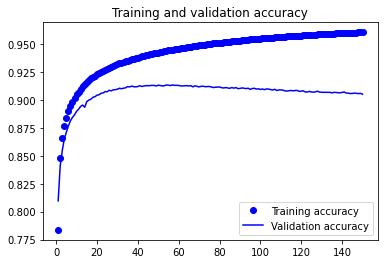

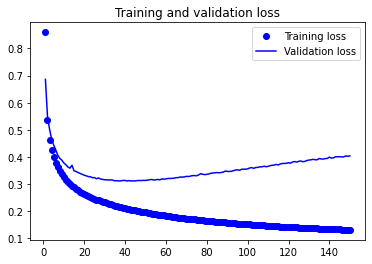

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [20]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [21]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [24]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data_tr[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts_train_n[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Tom, wake up.
Decoded sentence: Tom, kosten Sie es zu sim!

-
Input sentence: It rained heavily.
Decoded sentence: Es regnete spät.

-
Input sentence: No kidding?
Decoded sentence: Echt?

-
Input sentence: This is my coach.
Decoded sentence: Das ist mein Bleistift.

-
Input sentence: They work hard.
Decoded sentence: Sie wusst einen Versuch zun mich geben.

-
Input sentence: I was sent home.
Decoded sentence: Ich war sehr müde.

-
Input sentence: Clean that window.
Decoded sentence: Mach das Fenster sauer.

-
Input sentence: Show it to me.
Decoded sentence: Zeig es mir.

-
Input sentence: She is beautiful.
Decoded sentence: Sie ist schwach.

-
Input sentence: The lovers kissed.
Decoded sentence: Die Ristecht zu sicher.

-
Input sentence: Tom is faithful.
Decoded sentence: Tom ist freundlich.

-
Input sentence: Step aside.
Decoded sentence: Bleib brotzen!

-
Input sentence: Stop lying.
Decoded sentence: Hören Sie auf zu lügen.

-
Input sentence: Mary is my aunt.
Decode

In [26]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data_val[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts_val[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Tom does like you.
Decoded sentence: Tom hat nur eine Arbeit gefunden.

-
Input sentence: Tom does love you.
Decoded sentence: Tom hat das Beschend gefunden.

-
Input sentence: Tom doesn't agree.
Decoded sentence: Tom ertrinkte sich.

-
Input sentence: Tom doesn't agree.
Decoded sentence: Tom ertrinkte sich.

-
Input sentence: Tom doesn't drink.
Decoded sentence: Tom hat nicht geschickt.

-
Input sentence: Tom doesn't drive.
Decoded sentence: Tom hat es nicht gesehen.

-
Input sentence: Tom doesn't drive.
Decoded sentence: Tom hat es nicht gesehen.

-
Input sentence: Tom doesn't shave.
Decoded sentence: Tom hat nicht geschummelt.

-
Input sentence: Tom doesn't smoke.
Decoded sentence: Tom hat nicht gekommen.

-
Input sentence: Tom doesn't snore.
Decoded sentence: Tom hat nicht geschickt.

-
Input sentence: Tom donated blood.
Decoded sentence: Tom hat sich einen Hund gefalgen.

-
Input sentence: Tom drank heavily.
Decoded sentence: Tom trank Maria.

-
Input sentence: T

In [27]:
def str_to_tokens(sentence: str):
    #chars = list(sentence)
    tokens = list()
    input_data = np.zeros((1,max_encoder_seq_length, num_encoder_tokens),dtype='float32')
    for t, char in enumerate(sentence):
        if t >= max_encoder_seq_length:
            break
        if char in input_token_index:
            input_data[0,t, input_token_index[char]] = 1.
            tokens.append(char)
    input_data[0,t + 1:, input_token_index[' ']] = 1.
    if len(sentence) == 0 or len(tokens) == 0:
        return None
    else:
        return input_data

In [28]:
def eval_model(tok_input_data, raw_target_data,raw_input_data):
    predicted, actual = list(), list()
    tok_encoder = np.zeros((1,max_encoder_seq_length, num_encoder_tokens),dtype='float32')
    for i in range(len(tok_input_data)):
        tok_encoder[0] = tok_input_data[i]
        #if tok is None:
        #    continue
        translation = decode_sequence(tok_encoder).strip()
        raw_target = raw_target_data[i]
        raw_target = raw_target.strip()
        #if(raw_answer[len(raw_answer)])
        #if("end"==translation[len(translation)-3:]):
        #    translation = translation[:-3]
        if i < 10:
            raw_encoder = raw_input_data[i]
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_encoder, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # Bleu Scores
    print("##############################################")
    print(actual[0])
    print(predicted[0])
    print(' 1-gram score1: %f' % corpus_bleu(actual, predicted, weights=(1,0,0,0)))
    print(' 2-gram score1: %f' % corpus_bleu(actual, predicted, weights=(0,1,0,0)))
    print(' 3-gram score1: %f' % corpus_bleu(actual, predicted, weights=(0,0,1,0)))
    print(' 4-gram score1: %f' % corpus_bleu(actual, predicted, weights=(0,0,0,1)))
    print(' 4-gram score2: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [29]:
eval_model(encoder_input_data_val,target_texts_val,input_texts_val)

src=[Tom does like you.], target=[Tom mag dich.], predicted=[Tom hat nur eine Arbeit gefunden.]
src=[Tom does love you.], target=[Tom liebt dich wirklich.], predicted=[Tom hat das Beschend gefunden.]
src=[Tom doesn't agree.], target=[Tom stimmt nicht zu.], predicted=[Tom ertrinkte sich.]
src=[Tom doesn't agree.], target=[Tom ist nicht einverstanden.], predicted=[Tom ertrinkte sich.]
src=[Tom doesn't drink.], target=[Tom trinkt nicht.], predicted=[Tom hat nicht geschickt.]
src=[Tom doesn't drive.], target=[Tom fährt nicht.], predicted=[Tom hat es nicht gesehen.]
src=[Tom doesn't drive.], target=[Tom fährt nicht Auto.], predicted=[Tom hat es nicht gesehen.]
src=[Tom doesn't shave.], target=[Tom rasiert sich nicht.], predicted=[Tom hat nicht geschummelt.]
src=[Tom doesn't smoke.], target=[Tom raucht nicht.], predicted=[Tom hat nicht gekommen.]
src=[Tom doesn't snore.], target=[Tom schnarcht nicht.], predicted=[Tom hat nicht geschickt.]
##############################################
[['Tom

In [30]:
eval_model(encoder_input_data_tr,target_texts_train_n,input_texts_train_n)

src=[Tom, wake up.], target=[Steh auf, Tom!], predicted=[Tom, kosten Sie es zu sim!]
src=[It rained heavily.], target=[Es regnete heftig.], predicted=[Es regnete spät.]
src=[No kidding?], target=[Wirklich?], predicted=[Echt?]
src=[This is my coach.], target=[Das ist mein Trainer.], predicted=[Das ist mein Bleistift.]
src=[They work hard.], target=[Sie strengen sich an.], predicted=[Sie wusst einen Versuch zun mich geben.]
src=[I was sent home.], target=[Ich wurde nach Hause geschickt.], predicted=[Ich war sehr müde.]
src=[Clean that window.], target=[Mach das Fenster sauber.], predicted=[Mach das Fenster sauer.]
src=[Show it to me.], target=[Zeig ihn mir.], predicted=[Zeig es mir.]
src=[She is beautiful.], target=[Sie ist schön.], predicted=[Sie ist schwach.]
src=[The lovers kissed.], target=[Die Liebenden küssten sich.], predicted=[Die Ristecht zu sicher.]
##############################################
[['Steh', 'auf,', 'Tom!']]
['Tom,', 'kosten', 'Sie', 'es', 'zu', 'sim!']
 1-gram sc

In [ ]:
"""
def eval_model(raw_questions, raw_answers):
    predicted, actual = list(), list()
    for i in range(len(raw_questions)):
        raw_question = raw_questions[i]
        tok = str_to_tokens(raw_question)
        if tok is None:
            continue
        translation = decode_sequence(tok)
        raw_answer = raw_answers[i]
        raw_answer = raw_answer.replace('<start>','').replace('<end>','')
        #if(raw_answer[len(raw_answer)])
        if("end"==translation[len(translation)-3:]):
            translation = translation[:-3]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_question, raw_answer, translation))
        actual.append([raw_answer.split()])
        predicted.append(translation.split())
    # Bleu Scores
    print("##############################################")
    print(actual[0])
    print(predicted[0])
    print(' 1-gram score1: %f' % corpus_bleu(actual, predicted, weights=(1,0,0,0)))
    print(' 2-gram score1: %f' % corpus_bleu(actual, predicted, weights=(0,1,0,0)))
    print(' 3-gram score1: %f' % corpus_bleu(actual, predicted, weights=(0,0,1,0)))
    print(' 4-gram score1: %f' % corpus_bleu(actual, predicted, weights=(0,0,0,1)))
    print(' 4-gram score2: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
"""

In [32]:
exit_pro = False
while not exit_pro:
    input_seq = input('- - ')
    input_seq = input_seq.strip()
    print(input_seq in input_texts_train_n) 
    if input_seq == "--exit":
        exit_pro = True
    else:
        input_seq = str_to_tokens(input_seq)
        decoded_sentence = decode_sequence(input_seq)
        if decoded_sentence is None:
            print("Sorry, I can't translate this sentence")
        else:
            print(decoded_sentence)

- - Hi.
True
Halt’s!

- - Hello.
False
Warten Sie weg.

- - I like it.
True
Ich mag das.

- - Wait!
True
Warte!

- - Go.
True
Gehen.

- - Stop!
True
Haltag draußen!

- - I love you.
True
Ich liebe dich.

- - I hate you.
False
Ich hasse die Leuge.

- - You are a liar.
False
Du hast Milch.

- - What is your name!
False
Wie komme dir nach Hause!

- - What is your name?
False
Was ist mein Schlüssel?

- - Where do you live?
False
Wo ist dein Hund?

- - Hi.
True
Halt’s!

- - Hello.
False
Warten Sie weg.

- - No.
False
Num mir.

- - Yes
False
Die ist ein.

- - Yes.
False
Darinessen.

- - Where are you now!
False
Wo wird nie gelaufen!

- - Where are you now?
False
Wo ist dein Hund?

- - Do you love me?
True
Lieben Sie?

- - Don't move!
False
Nicht an die Weg!

- - Do you have any problems?
False


IndexError: index 19 is out of bounds for axis 1 with size 19